In [1]:
import os
import sys
import glob
import socket
import pickle
import importlib
import collections
import logging
logging.basicConfig(level=logging.INFO)

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV

SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'rnagps')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
from model_utils import single_train, ModelPerf, generate_model_perf
import model_utils
import plotting_utils

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)

np.random.seed(27492)
SEED = 27492

INFO:root:CPU


## HeLa

In [2]:
importlib.reload(data_loader)
hela_dir = os.path.join(data_loader.LOCAL_DATA_DIR, "encode/HeLa")
hela_nes_nls_dataset = data_loader.NLSvNESEncodeDataset(
    os.path.join(hela_dir, "deseq_hela.txt"),
    glob.glob(os.path.join(hela_dir, "*.tsv.gz")),
    split='all',
    kmer_sizes=[3, 4, 5],
    seq_by_parts=True,
)

INFO:root:7641/26166 entries in table retained as significant
INFO:root:Proportion of positives in all: 0.5265017667844523
INFO:root:4516	0.5910221175238843	Protein coding - containing ORF
INFO:root:581	0.07603716790995943	Alt spliced transcript with intronic sequence
INFO:root:553	0.07237272608297343	Processed transcript without ORF
INFO:root:501	0.06556733411857087	Antisense
INFO:root:462	0.060463290145268946	lincRNA
INFO:root:363	0.0475068708284256	Processed pseudogene
INFO:root:262	0.034288705666797537	Nonsense mediated decay
INFO:root:140	0.018322209134929983	Sense intronic
INFO:root:85	0.011124198403350346	Noncoding RNA predicted from Rfam and miRBase
INFO:root:65	0.008506739955503207	Pseudogene, unprocessed
INFO:root:65	0.008506739955503207	Pseudogene, partially expressed
INFO:root:27	0.0035335689045936395	Sense overlapping
INFO:root:5	0.0006543646119617851	To be experimentally confirmed
INFO:root:3	0.00039261876717707107	Pseudogene, specifes specific unprocessed without parent


In [3]:
hela_nes_nls_data = data_loader.load_data_as_np(hela_nes_nls_dataset)

In [4]:
with open("nes_nls_rf_model.sklearn", 'rb') as source:
    rf_nes_nls_model = pickle.load(source)

In [5]:
hela_preds = rf_nes_nls_model.predict_proba(hela_nes_nls_data[0])

In [6]:
# XIST is postive log2fc = 5.06303020896719
# XIST is nuclear
# Therefore 1 is nuclear, 0 is cytoplasmic
hela_perf = model_utils.generate_model_perf(
    hela_nes_nls_data[1],
    hela_preds[:, 0],
    multiclass=False,
)
print("AUROC")
hela_perf.auroc

AUROC


0.8140701332182406

In [7]:
print("AUPRC")
hela_perf.auprc

AUPRC


0.8358032961301644

## K562

In [8]:
importlib.reload(data_loader)
k562_dir = os.path.join(data_loader.LOCAL_DATA_DIR, "encode/k562")
k562_nes_nls_dataset = data_loader.NLSvNESEncodeDataset(
    os.path.join(k562_dir, "deseq_k562.txt"),
    glob.glob(os.path.join(k562_dir, "*.tsv.gz")),
    split='all',
    kmer_sizes=[3, 4, 5],
    seq_by_parts=True,
)

INFO:root:6359/25868 entries in table retained as significant
INFO:root:Proportion of positives in all: 0.514074540022016
INFO:root:3665	0.5763484824657965	Protein coding - containing ORF
INFO:root:682	0.10724956754206637	Alt spliced transcript with intronic sequence
INFO:root:514	0.08083031923258374	Processed transcript without ORF
INFO:root:330	0.05189495203648373	lincRNA
INFO:root:299	0.047019971693662524	Processed pseudogene
INFO:root:265	0.041673219059600565	Antisense
INFO:root:215	0.03381034753892121	Nonsense mediated decay
INFO:root:124	0.019499921371284794	Sense intronic
INFO:root:96	0.015096713319704356	Noncoding RNA predicted from Rfam and miRBase
INFO:root:73	0.011479792420191854	Pseudogene, unprocessed
INFO:root:57	0.00896367353357446	Pseudogene, partially expressed
INFO:root:19	0.002987891177858154	Sense overlapping
INFO:root:4	0.0006290297216543482	Immunoglobulin variable chain
INFO:root:4	0.0006290297216543482	Non stop decay (poly A features without prior stop codon in C

In [9]:
k562_nes_nls_data = data_loader.load_data_as_np(k562_nes_nls_dataset)

In [10]:
k562_preds = rf_nes_nls_model.predict_proba(k562_nes_nls_data[0])

In [11]:
# XIST is positive here as well
k562_perf = model_utils.generate_model_perf(
    k562_nes_nls_data[1],
    k562_preds[:, 0],
    multiclass=False,
)
print("AUROC")
k562_perf.auroc

AUROC


0.7979368808291284

## Load in the normal data so we can compare

In [12]:
parted_kmer_full_dataset = data_loader.NLSvNESDataset('all', kmer_sizes=[3, 4, 5], seq_by_parts=True)
parted_kmer_full_data = data_loader.load_data_as_np(parted_kmer_full_dataset)

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in all: 0.5280174767886401
INFO:root:5888	0.6431458219552157	Protein coding - containing ORF
INFO:root:693	0.07569634079737848	Processed transcript without ORF
INFO:root:686	0.07493173129437466	Antisense
INFO:root:581	0.06346258874931732	Alt spliced transcript with intronic sequence
INFO:root:504	0.05505188421627526	lincRNA
INFO:root:246	0.026870562534134352	Nonsense mediated decay
INFO:root:162	0.017695248498088477	Processed pseudogene
INFO:root:141	0.015401419989077007	Noncoding RNA predicted from Rfam and miRBase
INFO:root:116	0.012670671764063354	Sense intronic
INFO:root:45	0.004915346805024577	Pseudogene, unprocessed
INFO:root:34	0.003713817586018569	Pseudogene, partially expressed
INFO:root:33	0.003604587657018023	Sense overlapping
INFO:root:6	0.0006553795740032769	Pseudogene
INFO:root:5	0.0005461496450027307	To be experimentally confirmed
INFO:root:3	0.00032768978700163843	3prime over

In [13]:
parted_kmer_test_dataset = data_loader.NLSvNESDataset('test', kmer_sizes=[3, 4, 5], seq_by_parts=True)
parted_kmer_test_data = data_loader.load_data_as_np(parted_kmer_test_dataset)

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in test: 0.5131004366812227
INFO:root:597	0.6517467248908297	Protein coding - containing ORF
INFO:root:70	0.07641921397379912	Antisense
INFO:root:63	0.06877729257641921	Alt spliced transcript with intronic sequence
INFO:root:51	0.055676855895196505	Processed transcript without ORF
INFO:root:49	0.05349344978165939	lincRNA
INFO:root:35	0.03820960698689956	Nonsense mediated decay
INFO:root:13	0.014192139737991267	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:12	0.013100436681222707	Processed pseudogene
INFO:root:4	0.004366812227074236	Pseudogene, partially expressed
INFO:root:4	0.004366812227074236	Sense overlapping
INFO:root:3	0.0032751091703056767	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Non stop decay (poly A features without prior stop codon in CDS) subject to degradation
INFO:root:1	0.001091703056768559	To be experi

In [14]:
parted_kmer_test_perf = model_utils.generate_model_perf(
    parted_kmer_test_data[1],  # Array of 0/1
    rf_nes_nls_model.predict_proba(parted_kmer_test_data[0])[:, 1].flatten(),
    multiclass=False,
)
print("AUROC")
parted_kmer_test_perf.auroc

AUROC


0.854617879973285

## Comparison plot

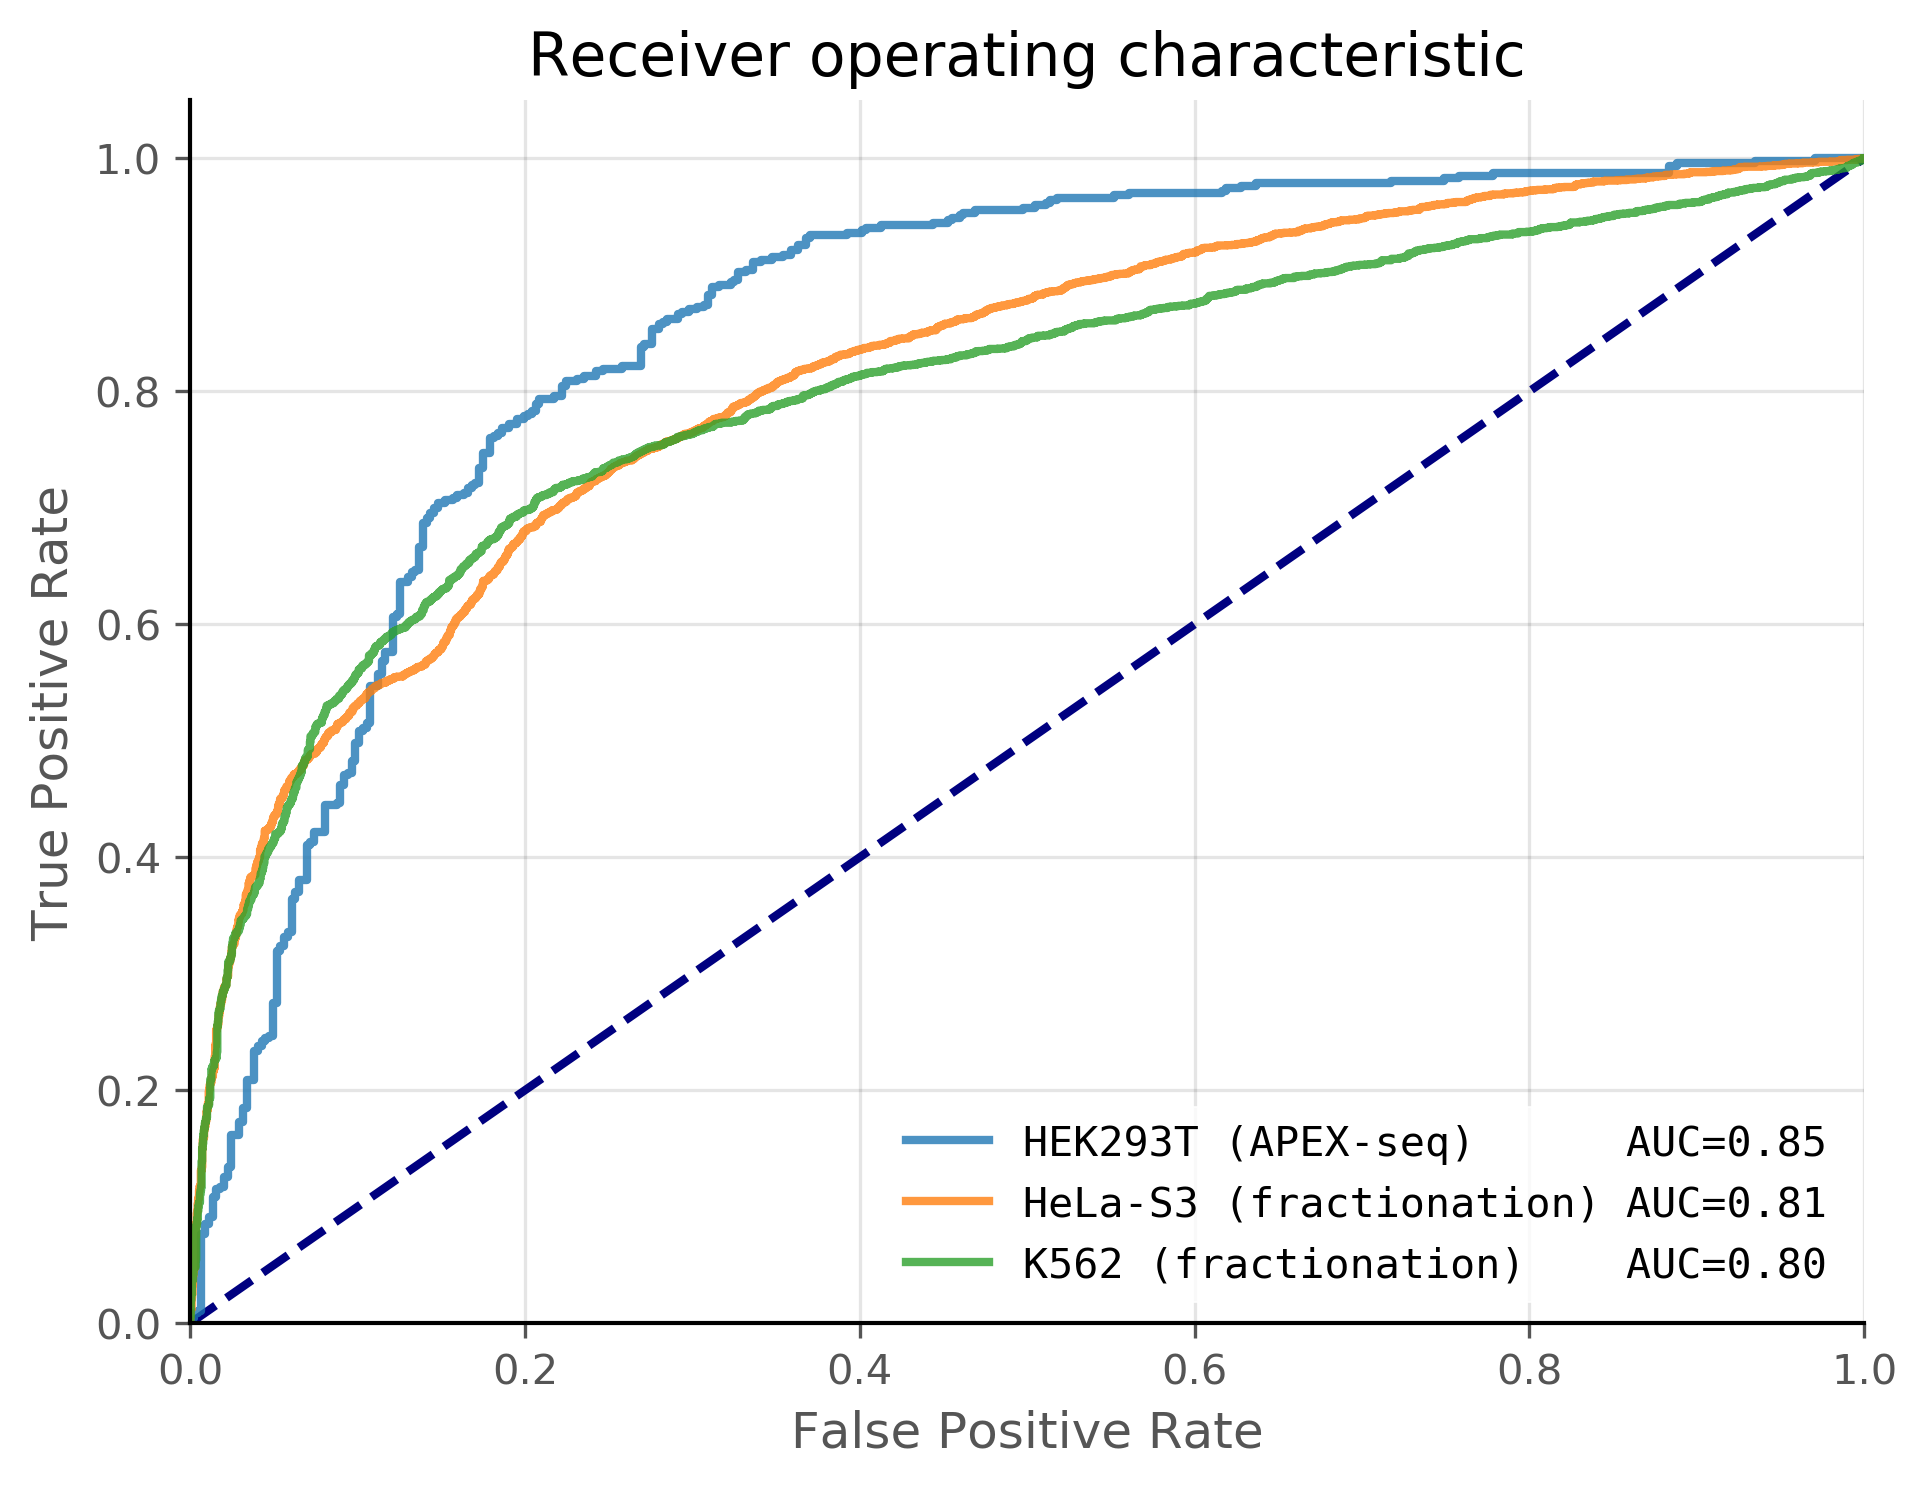

In [15]:
plotting_utils.plot_auroc(
    {
        "HEK293T (APEX-seq)": parted_kmer_test_perf,
        "HeLa-S3 (fractionation)": hela_perf,
        "K562 (fractionation)": k562_perf,
    },
    cmap="tab10",
    bg_color='white',
    grid=True,
    fname=os.path.join(PLOT_DIR, "external_cell_line_validation_auroc.pdf"),
)

## Exclude all transcripts that we've seen before in APEX-seq

In [16]:
apex_genes = list(parted_kmer_full_dataset.deseq_table_subsetted.index)
apex_transcripts = [parted_kmer_full_dataset.get_most_common_transcript(g) for g in apex_genes]
apex_transcripts[:5]

['ENST00000474048.1',
 'ENST00000371666.7',
 'ENST00000328434.7',
 'ENST00000241704.7',
 'ENST00000548358.1']

In [17]:
apex_genes[:5]

['ENSG00000134748.12',
 'ENSG00000131724.10',
 'ENSG00000183978.7',
 'ENSG00000122218.14',
 'ENSG00000139266.5']

In [18]:
k562_genes = list(k562_nes_nls_dataset.deseq_table_subsetted.index)
k562_genes[:5]

['ENSG00000205659.10',
 'ENSG00000176244.6',
 'ENSG00000197993.7',
 'ENSG00000254445.1',
 'ENSG00000176658.16']

In [19]:
k562_transcripts = [k562_nes_nls_dataset.get_most_common_transcript(g) for g in k562_genes]
k562_transcripts[:5]

['ENST00000555028.5',
 'ENST00000356189.5',
 'ENST00000355265.6',
 'ENST00000527616.1',
 'ENST00000318217.9']

In [20]:
len(set(k562_transcripts).intersection(set(apex_transcripts)))

1812

In [21]:
def get_intersection_bools(x, y, excl_period=True):
    """
    Given two lists of strings ENST or ENSG, return an array of size len(x)
    that is True if that element is in y, False otherwise
    """
    y_set = set([_y.split('.')[0] for _y in y]) if excl_period else set(y)
    if excl_period:
        x = [_x.split(".")[0] for _x in x]
    retval = [_x in y_set for _x in x]
    assert len(retval) == len(x)
    return np.array(retval, dtype=bool)

k562_gene_intersection_idx = get_intersection_bools(
    k562_genes,
    apex_genes,
    excl_period=True,
)
sum(k562_gene_intersection_idx), sum(~k562_gene_intersection_idx)

(3010, 3349)

In [22]:
k562_trans_intersection_idx = get_intersection_bools(
    k562_transcripts,
    apex_transcripts,
    excl_period=True,
)
sum(k562_trans_intersection_idx), sum(~k562_trans_intersection_idx)

(1812, 4547)

In [23]:
k562_nes_nls_data_excl_apex = (
    k562_nes_nls_data[0][~k562_trans_intersection_idx, :],
    k562_nes_nls_data[1][~k562_trans_intersection_idx]
)
k562_nes_nls_data_excl_apex[0].shape, k562_nes_nls_data_excl_apex[1].shape

((4547, 4032), (4547,))

In [24]:
k562_perf_excl_apex = model_utils.generate_model_perf(
    k562_nes_nls_data_excl_apex[1],
    rf_nes_nls_model.predict_proba(k562_nes_nls_data_excl_apex[0])[:, 0],
    multiclass=False,
)
print("AUROC")
k562_perf_excl_apex.auroc

AUROC


0.7329425647648836

In [25]:
hela_genes = list(hela_nes_nls_dataset.deseq_table_subsetted.index)
hela_genes[:5]

['ENSG00000270742.1',
 'ENSG00000188938.15',
 'ENSG00000172531.14',
 'ENSG00000172331.11',
 'ENSG00000064932.15']

In [26]:
hela_transcripts = [hela_nes_nls_dataset.get_most_common_transcript(g) for g in hela_genes]
hela_transcripts[:5]

['ENST00000603233.1',
 'ENST00000423591.5',
 'ENST00000376745.8',
 'ENST00000344924.7',
 'ENST00000361757.7']

In [27]:
hela_gene_intersection_idx = get_intersection_bools(
    hela_genes,
    apex_genes,
    excl_period=True,
)
sum(hela_gene_intersection_idx), sum(~hela_gene_intersection_idx)

(3573, 4068)

In [28]:
hela_trans_intersection_idx = get_intersection_bools(
    hela_transcripts,
    apex_transcripts,
    excl_period=True,
)
sum(hela_trans_intersection_idx), sum(~hela_trans_intersection_idx)

(2157, 5484)

In [29]:
hela_nes_nls_data_excl_apex = (
    hela_nes_nls_data[0][~hela_trans_intersection_idx, :],
    hela_nes_nls_data[1][~hela_trans_intersection_idx]
)
hela_nes_nls_data_excl_apex[0].shape, hela_nes_nls_data_excl_apex[1].shape

((5484, 4032), (5484,))

In [30]:
hela_perf_excl_apex = model_utils.generate_model_perf(
    hela_nes_nls_data_excl_apex[1],
    rf_nes_nls_model.predict_proba(hela_nes_nls_data_excl_apex[0])[:, 0],
    multiclass=False,
)
print("AUROC")
hela_perf_excl_apex.auroc

AUROC


0.7446496891923318

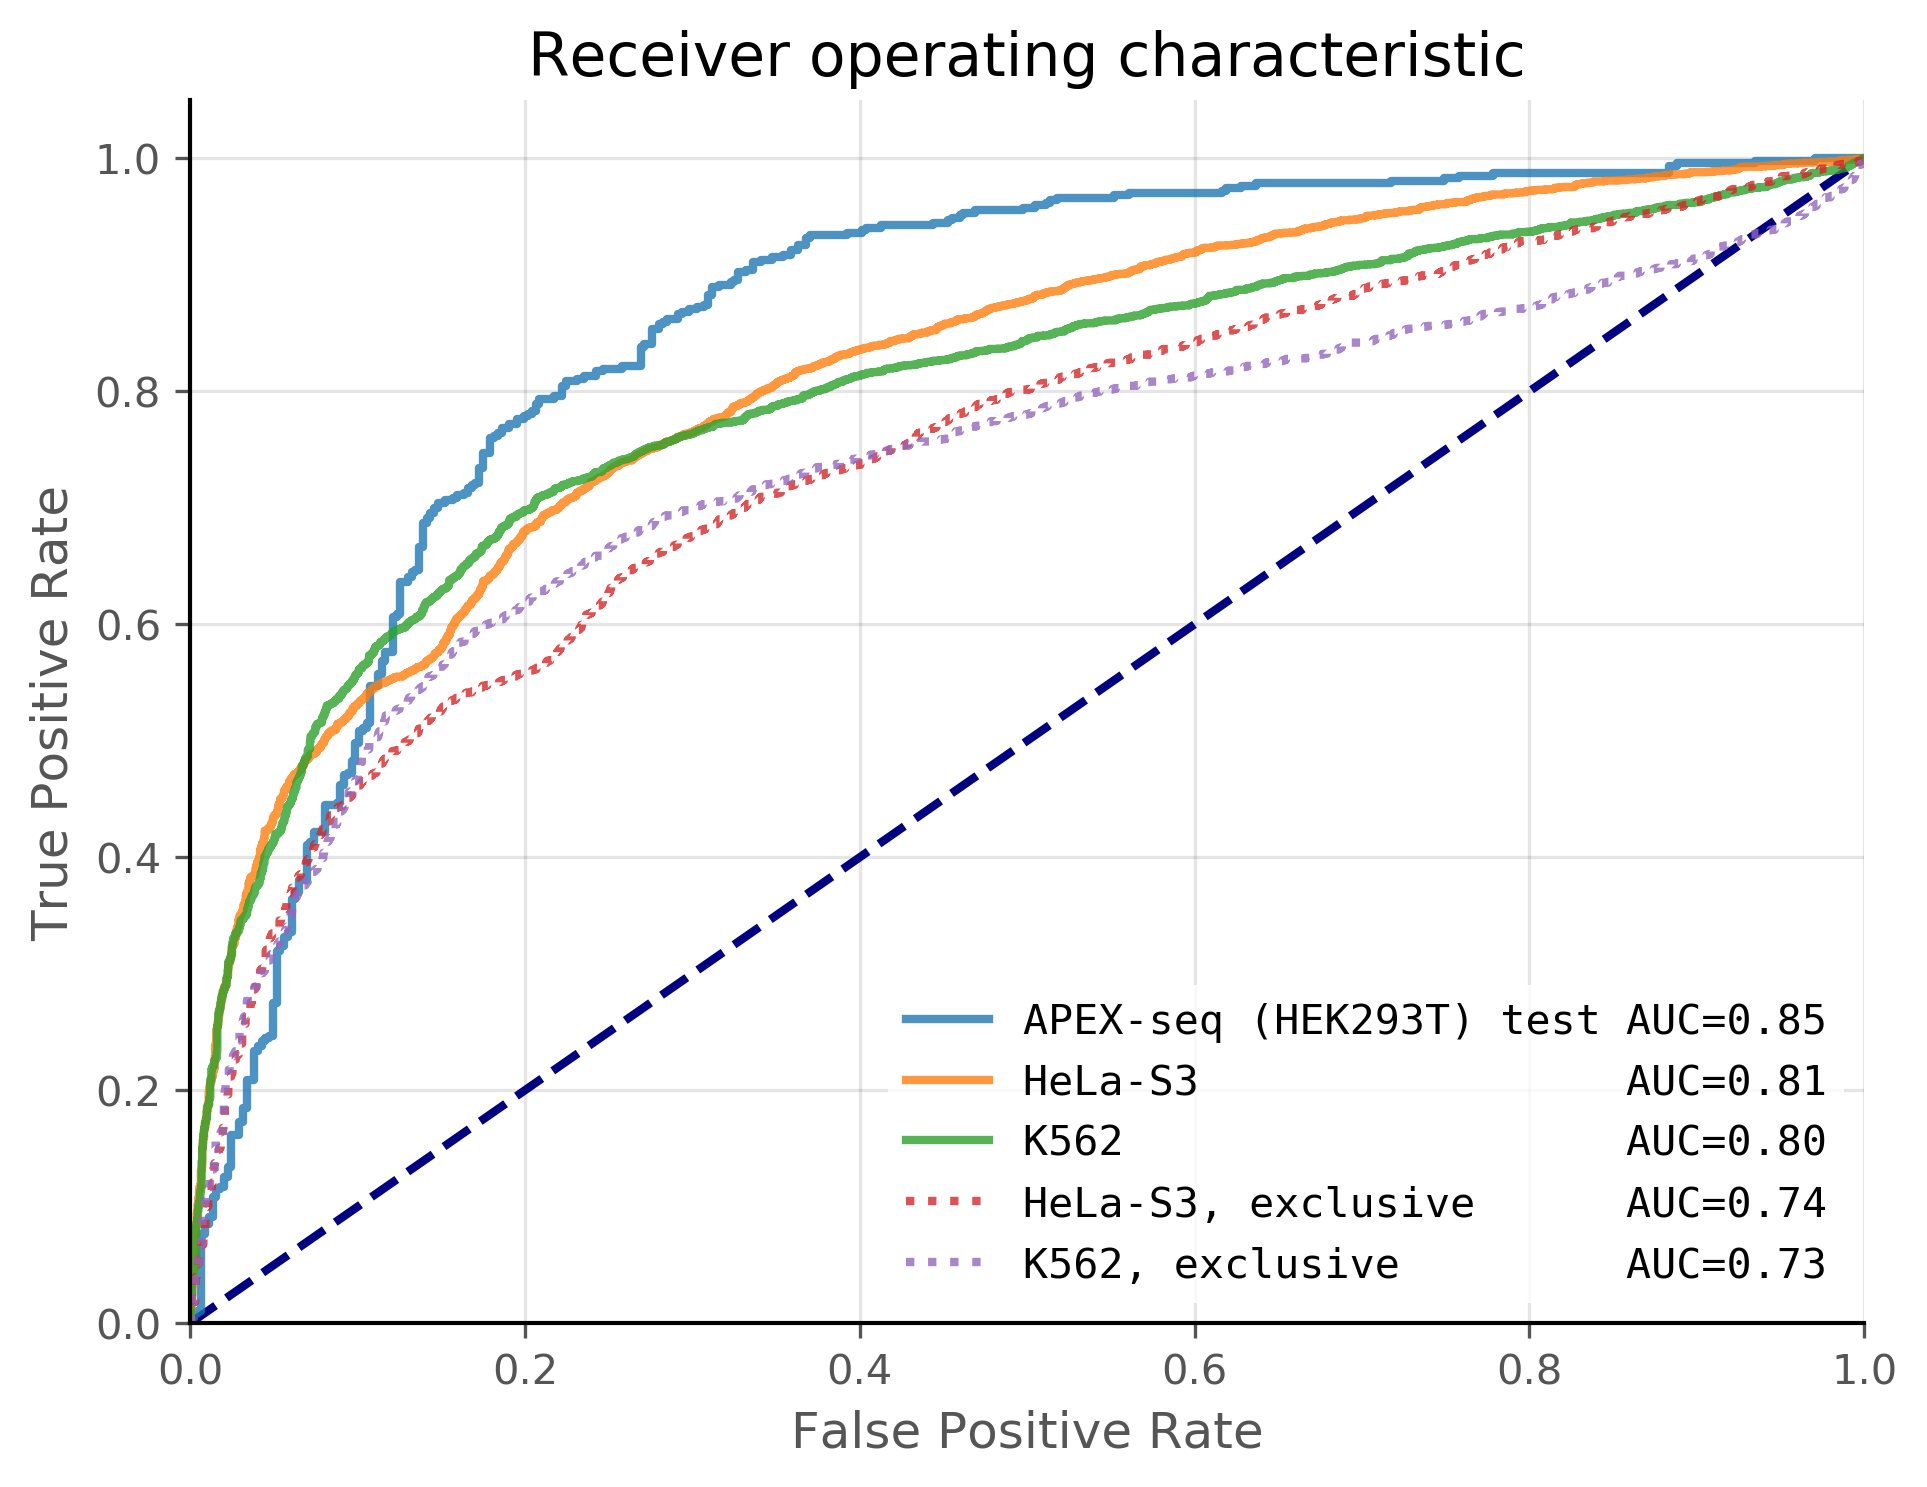

In [31]:
# Overall summary plot
importlib.reload(plotting_utils)
plotting_utils.plot_auroc(
    {
        "APEX-seq (HEK293T) test": parted_kmer_test_perf,
        "HeLa-S3": hela_perf,
        "K562": k562_perf,
        "HeLa-S3, exclusive": hela_perf_excl_apex,
        "K562, exclusive": k562_perf_excl_apex,
    },
    linestyle_dict={
        "HeLa-S3, exclusive": ":",
        "K562, exclusive": ":",
    },
    cmap="tab10",
    bg_color='white',
    grid=True,
)